In [157]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import optuna
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Input, Reshape, Dense, Flatten

In [122]:
df = pd.read_csv('intake.csv', index_col = 0)
df.shape

(146230, 12)

In [88]:
df.head()

,well_name,se,f_rotat_tm,f_rotat,q_fluid,wcutting,p_buff,p_buff_tm,p_intake,p_intake_tm,gas_factor,Пласт
4,45,ФОН,0.000000,39.603258,57.836844,75.827765,13.505952,10.052334,58.511816,58.511816,453.152714,НП5
13,45,ЭЦН,5634.000000,2382.288087,14.298030,46.327338,1.890838,13.255591,6.359354,69.382983,552.063709,НП4
17,45,ФОН,41.624372,32.224130,92.825847,1.074232,128.552900,128.552900,18.146463,56.465802,1750.618887,НП2
21,45,ЭЦН,2745.000000,1135.490483,25.868219,9.883491,14.283462,20.636887,226.976445,44.042330,2550.849913,НП7
25,45,ЭЦН,5336.000000,26.761057,56.821576,57.805315,67.463075,23.726925,128.803631,57.432689,1558.027999,НП1


In [90]:
df.drop(['f_rotat', 'p_buff', 'p_intake'], axis = 1, inplace=True)

# Кодирование категориальных признаков

* Кодирование признака "Пласт"

In [91]:
le = LabelEncoder()
df['Пласт'] = le.fit_transform(df['Пласт'])

In [92]:
n_unique = df['Пласт'].nunique()
output_shape = 2

input_layer = Input(shape=(1,))
plast_embedding = Embedding(input_dim = n_unique, output_dim = output_shape)(input_layer)
flatten_layer = Flatten()(plast_embedding)
output_layer = Dense(output_shape, activation = 'linear')(flatten_layer)

model = Model(inputs = input_layer, outputs = output_layer)
model.compile(optimizer = 'adam', loss = 'mse')

In [93]:
model.fit(df['Пласт'], df['p_intake_tm'], epochs = 10, batch_size = 64)

Epoch 1/10
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 3607.4465
Epoch 2/10
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 2s 991us/step - loss: 985.8953
Epoch 3/10
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 3s 984us/step - loss: 724.6711
Epoch 4/10
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 2s 988us/step - loss: 702.8134
Epoch 5/10
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 710.9725
Epoch 6/10
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 2s 974us/step - loss: 714.8810
Epoch 7/10
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 3s 982us/step - loss: 706.3518
Epoch 8/10
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 704.8112
Epoch 9/10
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 706.5650
Epoch 10/10
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 2s 987us/step - loss: 709.7812


In [97]:
embeddings = model.predict(df['Пласт'])

4570/4570 ━━━━━━━━━━━━━━━━━━━━ 3s 720us/step


In [98]:
df.drop(['Пласт', 'well_name'], axis = 1, inplace = True)

In [99]:
final_df = pd.concat([df.reset_index(drop=True), pd.DataFrame(embeddings).reset_index(drop=True)], axis = 1).rename({0: 'emb1', 1: 'emb2'})

In [102]:
final_df

,se,f_rotat_tm,q_fluid,wcutting,p_buff_tm,p_intake_tm,gas_factor,0,1
emb1,ФОН,0.000000,57.836844,75.827765,10.052334,58.511816,453.152714,60.454174,60.507290
emb2,ЭЦН,5634.000000,14.298030,46.327338,13.255591,69.382983,552.063709,60.347004,60.406147
2,ФОН,41.624372,92.825847,1.074232,128.552900,56.465802,1750.618887,60.562057,60.608894
3,ЭЦН,2745.000000,25.868219,9.883491,20.636887,44.042330,2550.849913,60.367893,60.394650
4,ЭЦН,5336.000000,56.821576,57.805315,23.726925,57.432689,1558.027999,60.740101,60.646320
...,...,...,...,...,...,...,...,...,...
146225,ЭЦН,40.811316,55.186565,6.679685,13.899824,74.622385,620.206865,60.514690,60.627209
146226,ЭЦН,5576.000000,15.424028,5.834916,15.590296,142.515666,742.867310,60.740101,60.646320
146227,ЭЦН,3221.000000,87.414426,37.260175,55.481780,64.338655,499.852530,60.514690,60.627209
146228,ЭЦН,2832.000000,157511.577326,0.000000,21.235488,58.808489,349.321030,60.094280,60.111797


* Кодирование признака "se"

In [104]:
df['se'] = df['se'].map({'ФОН':0, 'ЭЦН':1})

# Разбиение train\test\control

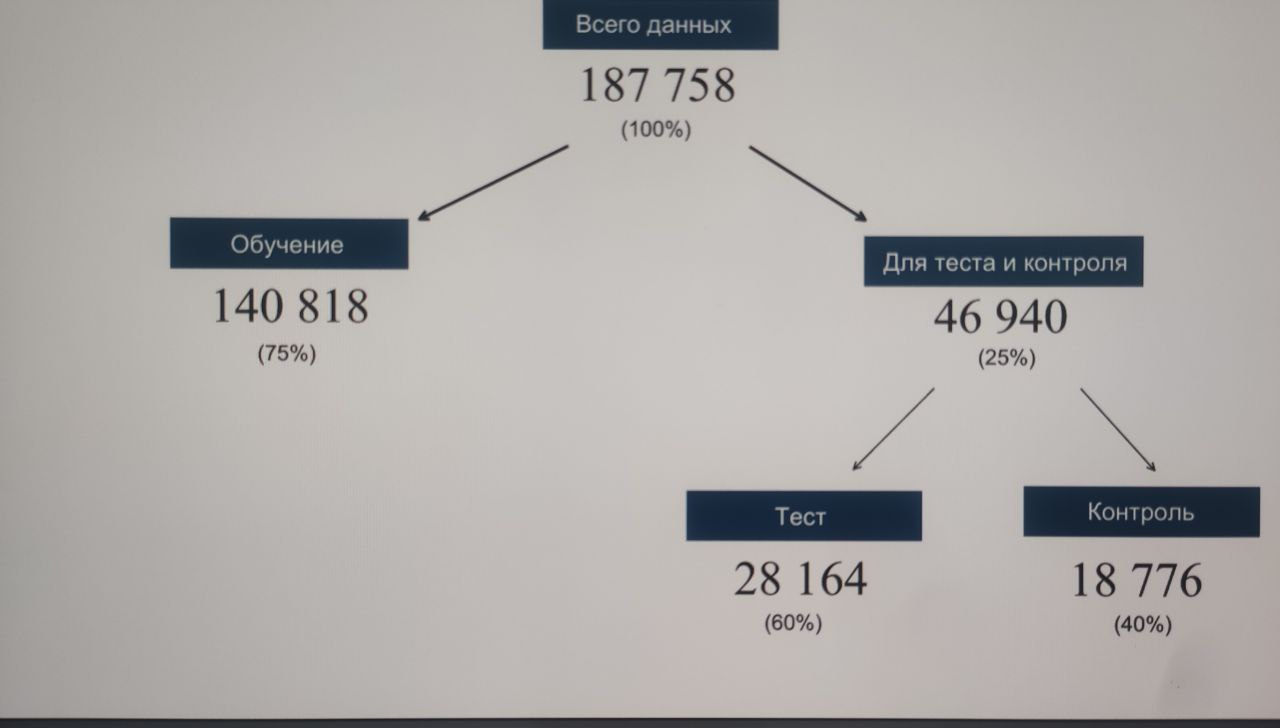

In [108]:
# Всего наблюдений
df.shape[0]

146230

In [109]:
# Обучение
df.shape[0] * 0.75

109672.5

In [110]:
# Тест и контроль
df.shape[0] * 0.25

36557.5

In [111]:
# Тест
df.shape[0] * 0.25 * 0.6

21934.5

In [112]:
# Контроль
df.shape[0] * 0.25 * 0.4

14623.0

* X_train, y_train - **Обучение**
* X_test, y_test - **Тест**
* X_control, y_control - **Контроль**

In [113]:
X = df.drop('p_intake_tm', axis=1)
y = df[['p_intake_tm']]

In [114]:
# Обучение и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [115]:
# Тест и контроль
X_test, X_control, y_test, y_control = train_test_split(X_test, y_test, test_size=0.4, random_state = 42)

In [116]:
# Обучение, тест, контроль
X_train.shape[0], X_test.shape[0], X_control.shape[0]

(109672, 21934, 14624)

# Создание моделей

In [151]:
df_metrics = pd.DataFrame(columns = ['model', 'RMSE', 'MSE', 'MAE'])

In [153]:
# Для внесения метрик в таблицу
def add_metrics(model, rmse, mse, mae, df_metrics):
    new_row = pd.DataFrame({
        'model': [model],
        'RMSE': [rmse],
        'MSE': [mse],
        'MAE': [mae]
    })
    return pd.concat([df_metrics, new_row], ignore_index=True)

## XGBRegressor

In [126]:
def objective(trial):
    params = {'max_depth': trial.suggest_int('max_depth', 3, 8),
           'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
           'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-2),
           'gamma': trial.suggest_uniform('gamma', 0, 5),
           'random_state': 42
           }
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return mse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print("Лучшие параметры:", study.best_params)

In [128]:
final_xgb = XGBRegressor(**study.best_params)
final_xgb.fit(X_train, y_train)
pred_test = final_xgb.predict(X_test)

In [129]:
mse_xgb = mean_squared_error(y_test, pred_test)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, pred_test)

In [154]:
df_metrics = add_metrics('XGBRegressor', rmse_xgb, mse_xgb, mae_xgb, df_metrics)

/tmp/ipython-input-153-354773167.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([df_metrics, new_row], ignore_index=True)


## CatBoostRegressor

In [138]:
def objective(trial):
    params = {'max_depth': trial.suggest_int('max_depth', 5, 12),
           'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
           'iterations': trial.suggest_int('iterations', 500, 2000, step=100),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20),
           'random_seed': 42
           }
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return mse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)
print("Лучшие параметры:", study.best_params)

In [ ]:
final_ctb = CatBoostRegressor(**study.best_params)
final_ctb.fit(X_train, y_train)
pred_test = final_ctb.predict(X_test)

In [142]:
mse_ctb = mean_squared_error(y_test, pred_test)
rmse_ctb = np.sqrt(mse_ctb)
mae_ctb = mean_absolute_error(y_test, pred_test)

In [155]:
df_metrics = add_metrics('CatBoostRegressor', rmse_ctb, mse_ctb, mae_ctb, df_metrics)

In [156]:
df_metrics

,model,RMSE,MSE,MAE
0,XGBRegressor,26.613470,708.276794,19.854378
1,CatBoostRegressor,26.613649,708.286335,19.854568


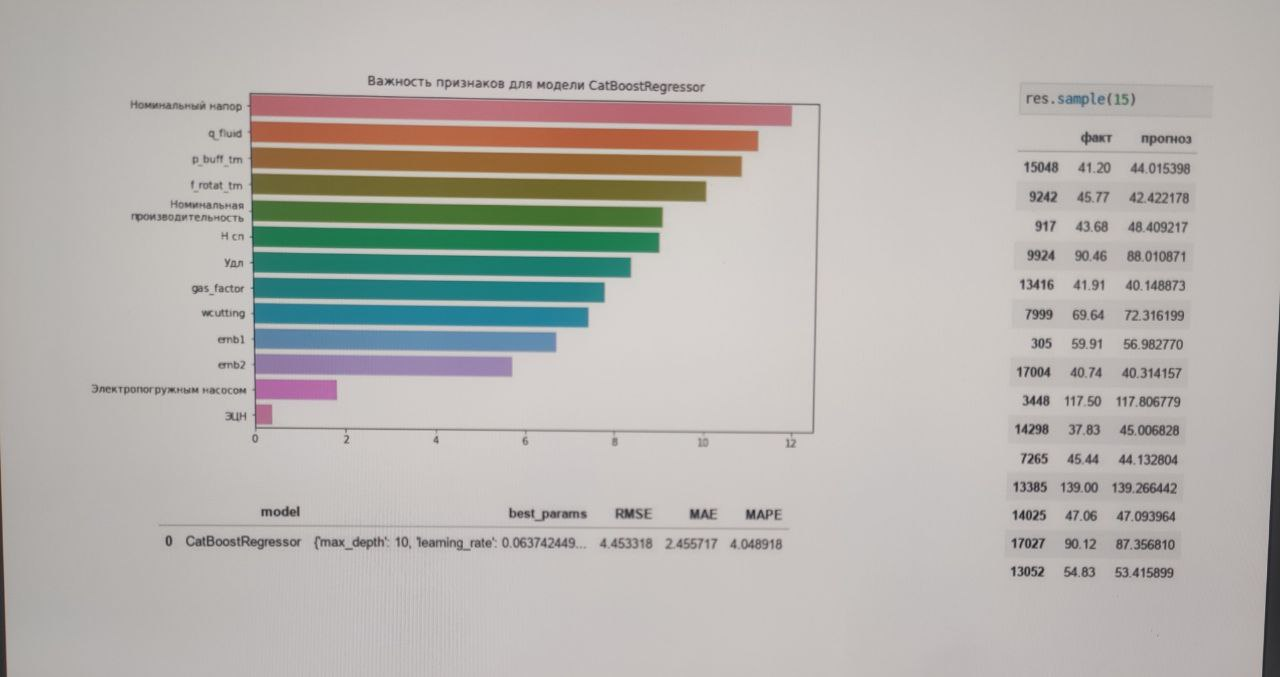

## RandomForestRegressor

In [160]:
def objective(trial):
    params = {'max_depth': trial.suggest_int('max_depth', 3, 8),
           'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
           'min_samples_split': trial.suggest_int('min_samples_split', 2, 5),
           'n_estimators': trial.suggest_int('n_estimators', 100, 700),
           'random_state': 42
           }
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return mse

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print("Лучшие параметры:", study.best_params)

In [ ]:
final_rf = RandomForestRegressor(**study.best_params)
final_rf.fit(X_train, y_train)
pred_test = final_rf.predict(X_test)

In [ ]:
mse_rf = mean_squared_error(y_test, pred_test)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, pred_test)

In [ ]:
df_metrics = add_metrics('RandomForestRegressor', rmse_rf, mse_rf, mae_rf, df_metrics)

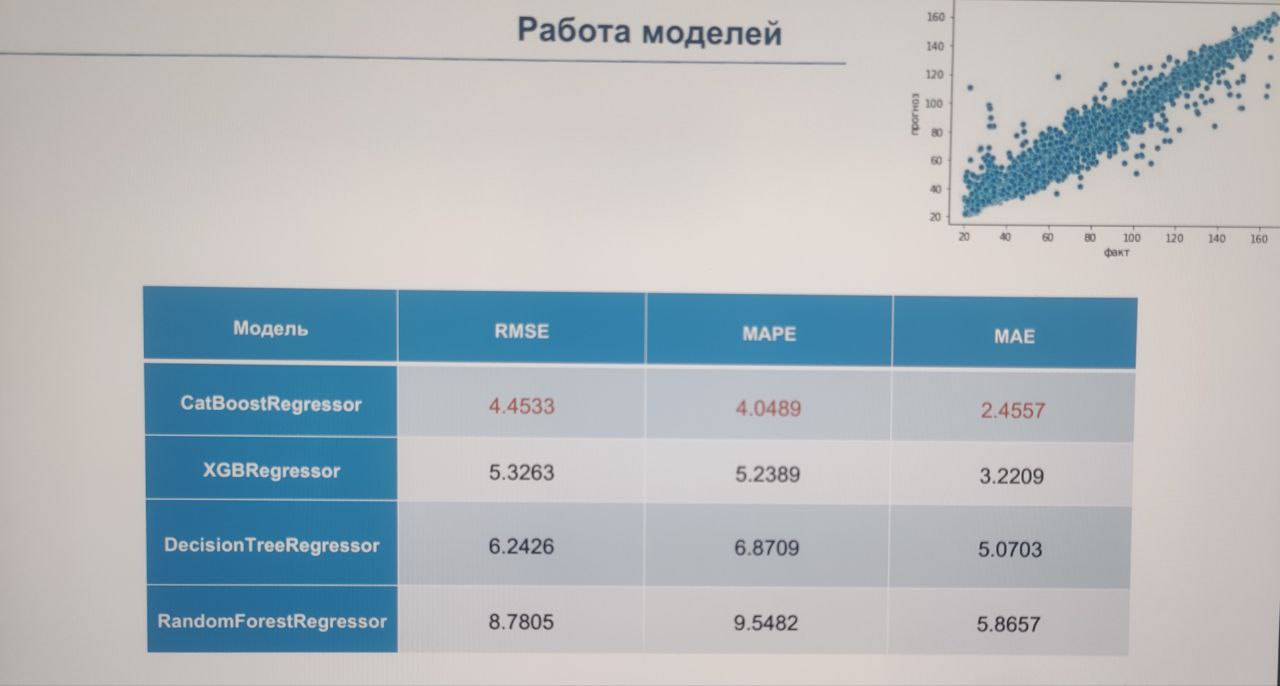

# Применение лучшей модели на контрольной выборке

In [162]:
preds_control = final_ctb.predict(X_control)

In [163]:
mse_ctrl = mean_squared_error(y_control, preds_control)
rmse_ctrl = np.sqrt(mse_ctrl)
mae_ctrl = mean_absolute_error(y_control, preds_control)

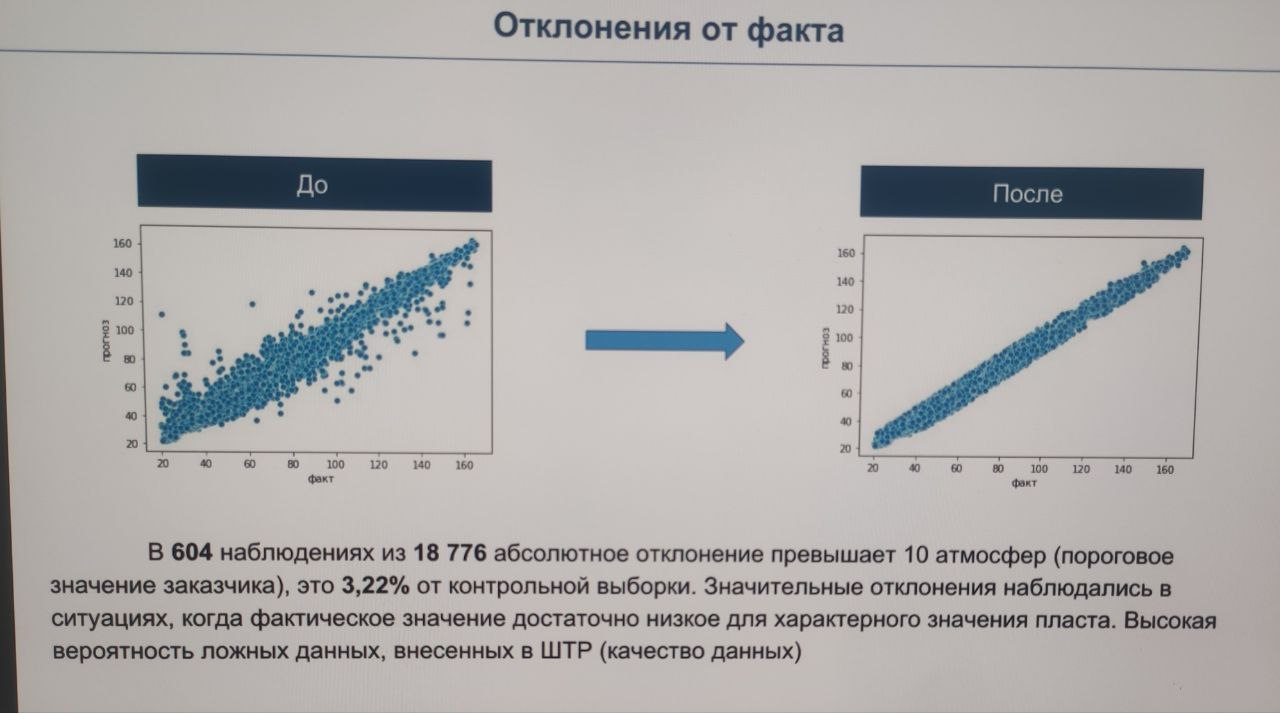